# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [1]:
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import matplotlib as mpl
import matplotlib.font_manager as fm

fm.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')

2.10.1


In [2]:
%matplotlib inline
import keras
import numpy as np
import random
np.random.seed(0)

from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical, pad_sequences, plot_model
from keras.models import load_model, Model
from keras import backend as K

# %matplotlib inline
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
# from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import Model
# from tensorflow.keras.models import load_model
# import tensorflow.keras.backend as K
# import numpy as np

# import random

## Load Dataset
We have generated a toy dataset using names of constituency MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/mp_name_th_en.csv", "/content/mp_name_th_en.csv")

In [4]:
import csv
with open('data/mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])

In [5]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## Task1: Preprocess dataset for Keras
* 2 dictionaries for indexing (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding)

#### **Create dictionaries for indexing**

In [6]:
#FILL YOUR CODE HERE

input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))

data_size, vocab_size = len(name_th), len(input_chars)+1 # 1 for padding
output_size, output_vocab_size = len(name_en), len(output_chars)+ 2 # 1 for padding 1 for end of word

print('data has %d names, %d unique characters in input, %d unique characters in output.' % (data_size, vocab_size, output_vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
print('max input length is', maxlen)

data has 10887 names, 65 unique characters in input, 24 unique characters in output.
max input length is 20


In [7]:
sorted_input_chars = sorted(input_chars)
sorted_output_chars = sorted(output_chars)

sorted_input_chars.insert(0,"<PAD>") #PADDING
sorted_output_chars.insert(0,"<EOS>") #END OF WORD
sorted_output_chars.insert(0,"<PAD>") #PADDING

# Input dictionary
input_char2idx = dict((c, i) for i, c in enumerate(sorted_input_chars))
input_idx2char = dict((i, c) for i, c in enumerate(sorted_input_chars))
# Output dictionary
output_char2idx = dict((c, i) for i, c in enumerate(sorted_output_chars))
output_idx2char = dict((i, c) for i, c in enumerate(sorted_output_chars))

print('input_char_indices', input_idx2char)
print('output_char_indices', output_idx2char)

input_char_indices {0: '<PAD>', 1: ' ', 2: 'ก', 3: 'ข', 4: 'ค', 5: 'ฆ', 6: 'ง', 7: 'จ', 8: 'ฉ', 9: 'ช', 10: 'ซ', 11: 'ฌ', 12: 'ญ', 13: 'ฎ', 14: 'ฏ', 15: 'ฐ', 16: 'ฑ', 17: 'ฒ', 18: 'ณ', 19: 'ด', 20: 'ต', 21: 'ถ', 22: 'ท', 23: 'ธ', 24: 'น', 25: 'บ', 26: 'ป', 27: 'ผ', 28: 'ฝ', 29: 'พ', 30: 'ฟ', 31: 'ภ', 32: 'ม', 33: 'ย', 34: 'ร', 35: 'ล', 36: 'ว', 37: 'ศ', 38: 'ษ', 39: 'ส', 40: 'ห', 41: 'ฬ', 42: 'อ', 43: 'ฮ', 44: 'ะ', 45: 'ั', 46: 'า', 47: 'ำ', 48: 'ิ', 49: 'ี', 50: 'ึ', 51: 'ื', 52: 'ุ', 53: 'ู', 54: 'เ', 55: 'แ', 56: 'โ', 57: 'ใ', 58: 'ไ', 59: '็', 60: '่', 61: '้', 62: '๊', 63: '๋', 64: '์'}
output_char_indices {0: '<PAD>', 1: '<EOS>', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'w', 23: 'y'}


#### **Define max length of input and output**

In [8]:
print('samplesize', data_size)
Tx = maxlen
Ty = Tx * 2 # We will use this length for output # output length is double of input length
# Ty = len(max(name_en, key=len)) # max output length # Not sure if this is correct and have enough space for output
print('max input length is', Tx)
print('max output length is', Ty)

samplesize 10887
max input length is 20
max output length is 40


#### **Pad sequences**

In [9]:
# Padding
X = []
for name in name_th:
    temp = []
    for char in name:
        temp.append(input_char2idx[char])
    X.append(temp)

Y = []
for name in name_en:
    temp = []
    for char in name:
        temp.append(output_char2idx[char])
    Y.append(temp)

print(f'Befor padding:')
xs = ''.join([input_idx2char[i] for i in X[0]])
print(f'Sample X: {X[0]} -> {xs}')
ys = ''.join([output_idx2char[i] for i in Y[0]])
print(f'Sample Y: {Y[0]} -> {ys}')

# We choose padding='post' because we want to pad after the sentence
X = pad_sequences(X, maxlen=Tx, padding='post', value=0)
Y = pad_sequences(Y, maxlen=Ty, padding='post', value=0)

print(f'After padding:')
xs = ''.join([input_idx2char[i] for i in X[0]])
print(f'Sample X: {X[0]} -> {xs}')
ys = ''.join([output_idx2char[i] for i in Y[0]]) 
print(f'Sample Y: {Y[0]} -> {ys}')

Befor padding:
Sample X: [58, 2, 34, 39, 49, 40, 64] -> ไกรสีห์
Sample Y: [12, 18, 3, 11, 19, 11] -> kraisi
After padding:
Sample X: [58  2 34 39 49 40 64  0  0  0  0  0  0  0  0  0  0  0  0  0] -> ไกรสีห์<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
Sample Y: [12 18  3 11 19 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] -> kraisi<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


#### **One-hot encode**

In [10]:
# One-hot encoding
X = to_categorical(X, num_classes=vocab_size)
Y = to_categorical(Y, num_classes=output_vocab_size)

X = X.reshape(data_size, Tx, vocab_size)
Y = Y.reshape(data_size, Ty, output_vocab_size)

print(f'X shape: {X.shape}')
print(f'Y shape: {Y.shape}')

X shape: (10887, 20, 65)
Y shape: (10887, 40, 24)


#### **All in one function**

In [11]:
def data_trans(data_list,datatype="input"):
    # Transforms data into a list of indices via the dictionary
    output = []
    for data in data_list:
        temp = []
        for char in data:
            if datatype == "input":
                temp.append(input_char2idx[char])
            elif datatype == "output":
                temp.append(output_char2idx[char])
        output.append(temp)
    # Pad the sequences with 0s <PAD>
    if datatype == "input":
        output = pad_sequences(maxlen=Tx, sequences=output, padding="post", value=0)
    elif datatype == "output":
        output = pad_sequences(maxlen=Ty, sequences=output, padding="post", value=0)
    # Convert to one-hot vectors
    if datatype == "input":
        output = to_categorical(output, num_classes=vocab_size)
    elif datatype == "output":
        output = to_categorical(output, num_classes=output_vocab_size)
    return output

# Attention Mechanism
## Task 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* Hint: you will probably need more hidden dimmensions than what you've seen in the demo


In [12]:
from keras.activations import softmax
from keras.layers import Lambda

def softMaxAxis1(x):
    return softmax(x,axis=1)

In [13]:
#These are global variables (shared layers)
## Fill your code here
## you are allowed to use code in the demo as your template. 

#repeater = ???
#concatenator = ???
repeator = RepeatVector(Tx, name='repeatorA')
concatenator = Concatenate(axis=-1, name='concatenatorA')

#Key-values (Hint)
splitter = Lambda(lambda x:tf.split(x, num_or_size_splits=2,axis=2), name='splitterA') 

#fatten_1 = ???
#fatten_2 = ???
fatten_1 = Dense(1, activation = "tanh", name = "fatten_1A")
fatten_2 = Dense(1, activation = "relu", name = "fatten_2A")

#activator = ???
activator = Activation(softMaxAxis1, name='attention_scoreA') # We are using a custom softmax(axis = 1) loaded in this notebook
#dotor = ???
dotor = Dot(axes = 1, name='dotorA')

In [14]:
def one_step_attention(a, s_prev):

    # #Fill code here
    # #key, value = ???
    
    #concat = ...key...

    #context = ...value...

    # From Equation in the slides a = h (hidden state)(input), s_prev = s_{t-1} (Previous hidden state)
    # Get Key and Value from a (h) = [key, value]
    [key, value] = splitter(a)

    # From Equation in the slides 
    # Find M and pass it through a tanh layer
    # M is the concatenation of the previous hidden state and the current hidden state
    s_prev = repeator(s_prev)
    # Use key and s_prev to find M
    concat = concatenator([key, s_prev])
    e = fatten_1(concat)

    # Find energies and pass it through a relu layer
    energies = fatten_2(e)

    # Calculate attention scores through softmax
    attention_scores = activator(energies)

    # Find context vector with attention scores and value (Concept of key-value attention)
    context = dotor([attention_scores, value])
 
    return context, attention_scores , energies # return whatever you need to complete this homework 

## Task3: Create and train your encoder/decoder model here
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [15]:
#FILL CODE HERE :Hint --> heatmap in CNN + GradCAM

# def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
#   ...

# def inference_encoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
#    X = ....
#    h = ....

#    model = Model(inputs=[X],outputs=h)
#    return model

# def inference_decoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
#   s0 = ...
#   c0 = ...
#   h = ...
#   context, attention_scores, energies = one_step_attention(h, s)
#   ...decoder_LSTM_cell...
#   out = output_layer(s)

#   model = Model(inputs=[h,s0,c0],outputs=[out,s,c,atten_score,energies])

#   return model

### **Define Shared Layers**

In [16]:
# Define shared layers (as global variables) to be used in the training model and inference models
n_h = 32 #hidden dimensions for encoder 
n_s = 64 #hidden dimensions for decoder
# Encoder Bi-LSTM
encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2), name = 'encoder_LSTM') #encoder_LSTM
# Decoder LSTM
decoder_LSTM_cell = LSTM(n_s, return_state = True, name='decoder_LSTM_cell') #decoder_LSTM_cell
# Dense layer to generate output
output_layer = Dense(output_vocab_size, activation="softmax", name='output_layerA') #output_layer

### **Create Model**

In [17]:
def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size), name='Encoder_Input')
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()
    
    # Encoder Bi-LSTM
    h = encoder_LSTM(X)
    
    # Iterate for Ty steps
    for t in range(Ty):
        # Perform one step of the attention mechanism to get back the context vector at step t
        # Edit the function one_step_attention() to get the context vector at each time step
        context, attention_scores, energies = one_step_attention(h, s) # Use only the context vector at each time step
        
        # Apply the post-attention LSTM cell to the "context" vector.
        s, _, c = decoder_LSTM_cell(context, initial_state=[s, c])
        
        # Apply Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)
        
        # Append "out" to the "outputs" list
        outputs.append(out)
    
    # Create model instance
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
    return model

In [18]:
# def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    
#     # Initialize empty list of outputs
#     outputs = list()
    
#     # Set up encoder 
#     encoder_input = Input(shape=(Tx, vocab_size))
#     encoderLSTM = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))
#     # Encoder output 1. encoder_output, 2. encoder_hidden_state, 3. encoder_cell_state
#     encoder_output, state_h, state_c = encoderLSTM(encoder_input)
    
#     # Define encoder states
#     encoder_states = [state_h, state_c]
    
#     # Set up decoder

#     # Define decoder initial states
#     decoder_state_input_h = Input(shape=(n_s,), name='s0')
#     decoder_state_input_c = Input(shape=(n_s,), name='c0')
#     state_s = decoder_state_input_h
#     state_c = decoder_state_input_c
    
#     # Set up decoder LSTM
#     decoderLSTM = LSTM(n_s, return_state = True) #decoder_LSTM_cell
    
#     for t in range(Ty):
#         # Perform one step of the attention mechanism to get back the context vector at step t
#         context, attention_scores, energies = one_step_attention(encoder_output, state_s)
        
#         # Apply the post-attention LSTM cell to the "context" vector.
#         # Decoder output 1. decoder output 2. decoder state 3. decoder cell state
#         state_s, _ , state_c = decoderLSTM(context, initial_state=[state_s, state_c])
        
#         # Apply Dense layer to the hidden state output of the post-attention LSTM
#         out = Dense(machine_vocab_size, activation="softmax")(state_s)
        
#         # Append "out" to the "outputs" list
#         outputs.append(out)
        
#     # Create model instance
#     model = Model(inputs=[encoder_input, decoder_state_input_h, decoder_state_input_c], outputs=outputs)
    
#     return model

### **Compile Model**

In [19]:
model = model(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_Input (InputLayer)     [(None, 20, 65)]     0           []                               
                                                                                                  
 encoder_LSTM (Bidirectional)   (None, 20, 64)       25088       ['Encoder_Input[0][0]']          
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 splitterA (Lambda)             [(None, 20, 32),     0           ['encoder_LSTM[0][0]',           
                                 (None, 20, 32)]                  'encoder_LSTM[0][0]',       

In [20]:
opt = Adam(learning_rate=0.001) 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

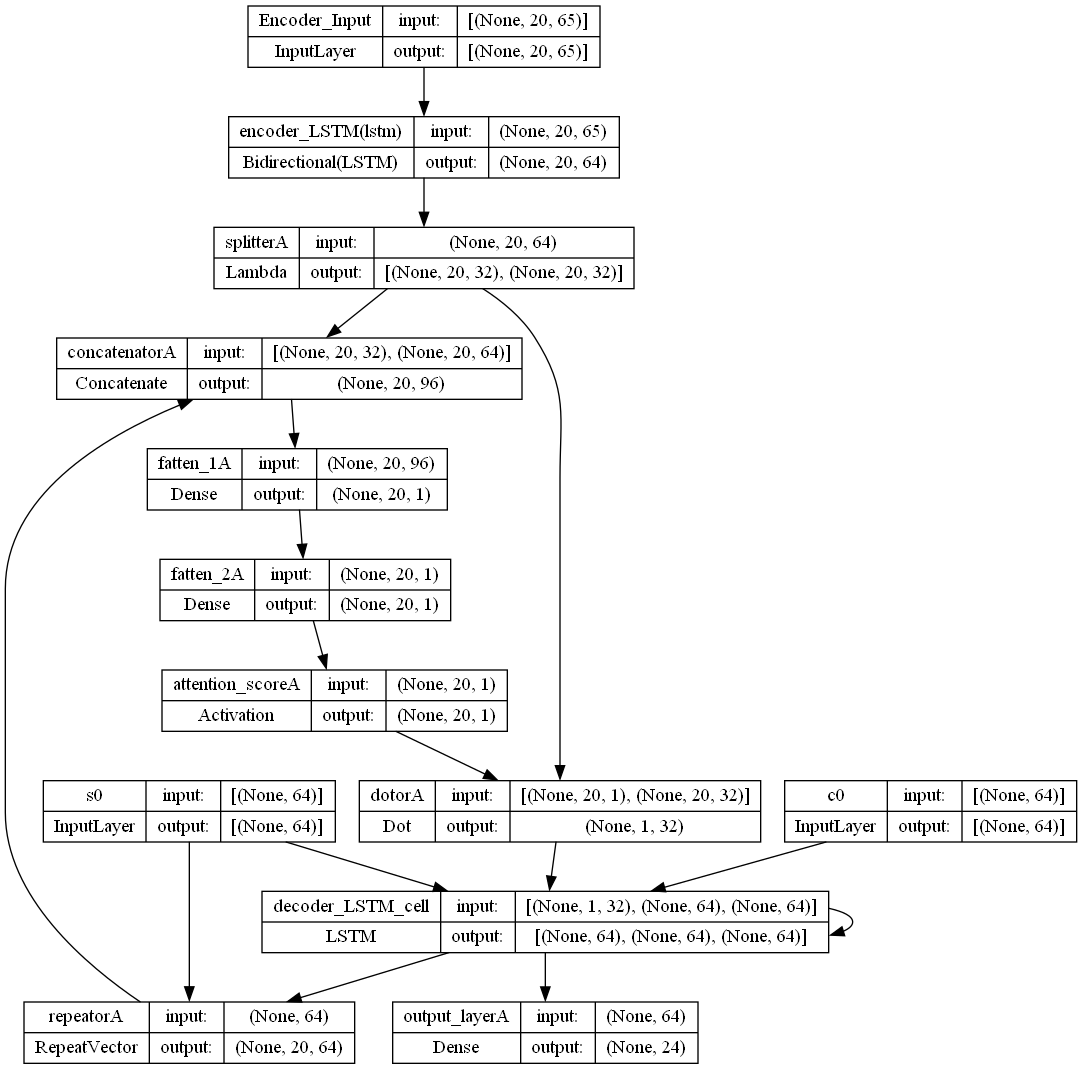

In [21]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### **Model Training**

#### **Initialize Decoder State**

In [22]:
# Initialize s0 and c0
# With vocab_size, n_s = 64 hidden dimensions of the decoder
s0 = np.zeros((data_size, n_s))
c0 = np.zeros((data_size, n_s))
# Create a list of outputs
# We need to swap the axis because the model expects the output to be of shape (Ty, data_size, vocab_size)
outputs = list(Y.swapaxes(0,1))
print(f'Y shape: {Y.shape} and outputs shape: {np.array(outputs).shape}')

Y shape: (10887, 40, 24) and outputs shape: (40, 10887, 24)


#### **Train Model**

In [23]:
# model.fit([X, s0, c0], outputs, epochs=100, batch_size=64, verbose=1)

### **Inference Model**

In [24]:
def inference_encoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_sizem):
   # Encoder input shape = Tx, vocab_size
   X =  Input(shape=(Tx, vocab_size))
   # Encoder Bi-LSTM from model() output shape = None, Tx, n_h*2
   h = encoder_LSTM(X)
   model = Model(inputs=[X],outputs=h)
   return model

def inference_decoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
   # Decoder input shape = inference_encoder output shape = None, Tx, n_h*2 , n_h*2 = n_s
   h = Input(shape=(inference_encoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size).output_shape[1], n_h*2))
   # Decoder initial states
   s0 = Input(shape=(n_s,), name='s0')
   c0 = Input(shape=(n_s,), name='c0')
   s = s0
   c = c0
   # Note: We are using the same decoder LSTM cell that was trained
   # Don't need to be looped over Ty because we are doing one step at a time
   context, attention_scores, energies = one_step_attention(h, s)
   s, _, c = decoder_LSTM_cell(context, initial_state=[s, c])
   out = output_layer(s)
   # Create model instance
   model = Model(inputs=[h,s0,c0],outputs=[out,s,c,attention_scores,energies])
   return model

In [25]:
# Use the shared layers to build the inference models
inference_encoder_model = inference_encoder(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)
inference_decoder_model = inference_decoder(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)

## **Save Model**

In [26]:
# model.save('fit_model')
# inference_encoder_model.save('inference_encoder_model')
# inference_decoder_model.save('inference_decoder_model')

## **Load Model**

In [27]:
model = load_model('fit_model', custom_objects={'one_step_attention': one_step_attention})
inference_encoder_model = load_model('inference_encoder_model', custom_objects={'one_step_attention': one_step_attention})
inference_decoder_model = load_model('inference_decoder_model', custom_objects={'one_step_attention': one_step_attention})

# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! 
* Task 5: Show your visualization of attention scores on one of your example 

In [28]:
#task 4
#fill your code here
EXAMPLES_ = ["อธิเมศร์",'สรพัศ',"ธนัช","มิก","ซ้ง","ออมซ์"]
X_ = data_trans(EXAMPLES_, datatype='input')
# Initialize s0 and c0
s0_ = np.zeros((len(EXAMPLES_), n_s))
c0_ = np.zeros((len(EXAMPLES_), n_s))
print(X_.shape)

(6, 20, 65)


In [29]:
pred_ = model.predict([X_, s0_, c0_])
pred_ = np.array(pred_)
print(f'Initial prediction shape: {pred_.shape} (Ty, data_size, vocab_size)')
# Swap the axis because the model expects the output to be of shape (m, Ty, vocab_size)
pred_ = pred_.swapaxes(0,1)
print(f'Prediction shape after swapping axis: {pred_.shape} (data_size, Ty, vocab_size)')
# Argmax to get the index of the highest probability
pred_ = np.argmax(pred_, axis=-1)
# Display the predictions
for j in range(len(pred_)):
    temp = [c for c in pred_[j] if c != 0]
    output_ = ''.join([output_idx2char[i] for i in temp])
    print("input: ", EXAMPLES_[j], "output: ", output_)

1/1 [==============================] - 28s 28s/step
Initial prediction shape: (40, 6, 24) (Ty, data_size, vocab_size)
Prediction shape after swapping axis: (6, 40, 24) (data_size, Ty, vocab_size)
input:  อธิเมศร์ output:  athimat
input:  สรพัศ output:  sonphat
input:  ธนัช output:  thanat
input:  มิก output:  mik
input:  ซ้ง output:  song
input:  ออมซ์ output:  om


### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
--> https://drive.google.com/file/d/168J5SPSf4NNKj718wWUEDpUbh8QYZKux/view?usp=share_link

In [30]:
# EXAMPLES = ???
# h = inferEncoder_model.predict(EXAMPLES)
# s0 = ???
# c0 = ???
# ...
# Ty = 10
# for t in range(Ty):
#   out,s,c,attention_scores,energies = inferDecoder_model.predict([h,s0,c0])
# ...


In [52]:
# Predict the output
EXAMPLES_ = ['อธิเมศร์']
EXAMPLES = data_trans(EXAMPLES_, datatype='input')
# Get the encoder output
h = inference_encoder_model.predict(EXAMPLES)
# Initialize s0 and c0
s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
# Create lists to contain the outputs
list_attention = []
list_prediction = []
# For loop over Ty(output length)
for t in range(Ty):
    # Perform one step of the attention decoder to get the output
    out,s,c,attention_scores,energies = inference_decoder_model.predict([h,s0,c0])
    # Update the initial state to be the previous state
    s0 = s
    c0 = c
    # Get the prediction
    # Initiali out shape is (1,vocab_size) 
    # Swap the axis (vocab_size,1)
    pred = np.swapaxes(out, 0, 1) 
    # Get the index of the highest probability of dimension 1 (vocab_size(a-z))
    pred = np.argmax(pred, axis=0)
    # Get data from array
    pred = pred[0]
    # Append the prediction to the list
    if pred == 0: # <EOS>
        # Stop the loop because we have reached the end of the output
        break
    else :
        try: # In case of Thai character has few characters than English
            print(t, ": input -->", EXAMPLES_[0][t], "output -->", output_idx2char[pred], '(',pred,')')
        except: # if that EXAMPLES_[0][t] is out of range
            print(t, ": input -->", ' ', "output -->", output_idx2char[pred], '(',pred,')')
        print(attention_scores.reshape(-1))
        list_attention.append(attention_scores.reshape(-1))
        list_prediction.append(output_idx2char[pred])

1/1 [==============================] - 0s 40ms/step
0 : input --> อ output --> a ( 3 )
[0.49363047 0.19670457 0.01923161 0.01728993 0.01707146 0.01707146
 0.01707146 0.01707146 0.01707146 0.01707146 0.01707146 0.01707146
 0.01707146 0.01707146 0.01707146 0.01707146 0.01707146 0.01707146
 0.01707146 0.01707146]
1/1 [==============================] - 0s 50ms/step
1 : input --> ธ output --> t ( 20 )
[0.3577467  0.3481117  0.10213424 0.02013135 0.01156147 0.01077151
 0.01066476 0.0109841  0.01064548 0.01064522 0.01064522 0.01064522
 0.01064522 0.01064522 0.01064522 0.01064522 0.01064614 0.01066403
 0.01069104 0.01073096]
1/1 [==============================] - 0s 37ms/step
2 : input --> ิ output --> h ( 10 )
[0.23649968 0.23628101 0.22177233 0.14899288 0.03127783 0.01031462
 0.00798932 0.01549066 0.00759387 0.00721004 0.00710958 0.00708781
 0.00710161 0.0071456  0.00723022 0.0073744  0.00760735 0.00797423
 0.00854122 0.00940576]
1/1 [==============================] - 0s 39ms/step
3 : input 

In [53]:
# Print the list of predictions
print(''.join(list_prediction))

athimat


In [54]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you
#fill your code here

In [55]:
temp = [input_idx2char[input_char2idx[char]] for char in EXAMPLES_[0]]

In [56]:
xaxis = temp
print(xaxis)

['อ', 'ธ', 'ิ', 'เ', 'ม', 'ศ', 'ร', '์']


In [57]:
yaxis = list_prediction
print(yaxis)

['a', 't', 'h', 'i', 'm', 'a', 't']


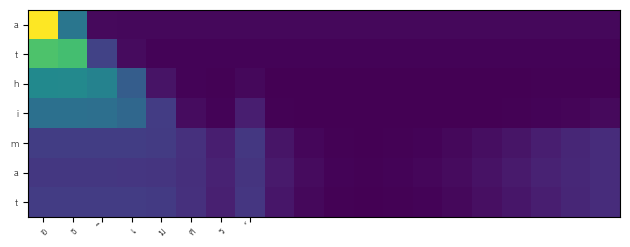

In [58]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you
#fill your code here

fig, ax = plt.subplots()
im = ax.imshow(np.array(list_attention))

ax.set_xticks(np.arange(len(xaxis)), labels=xaxis)
ax.set_yticks(np.arange(len(yaxis)), labels=yaxis)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

fig.tight_layout()
plt.show()